In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer


In [10]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
# Then, freeze the base model.

base_model.trainable = False
# Create a new model on top.

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)
# Train the model on new data.

optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1.0, noise_multiplier=1.1, num_microbatches=250, learning_rate=0.15)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [11]:
from tensorflow import keras

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images,
                               test_labels) = keras.datasets.cifar10.load_data()

train_images = train_images[:1000]
train_labels = train_labels[:1000]

train_images = tf.image.resize(train_images, [150, 150])
test_images = tf.image.resize(test_images, [150, 150])

# Normalize the pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert the labels to binary format (0 or 1)
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)


In [22]:
num_epochs = 4
batch_size = 250
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(
            zip(train_images, train_labels)):
        # expand dims
        x_batch_train = tf.expand_dims(x_batch_train, axis=0)
        y_batch_train = tf.expand_dims(y_batch_train, axis=0)
        # compute gradients
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(
                y_batch_train, logits, from_logits=True)
        # call optimizer.compute_gradients
        grads = tape.gradient(loss_value, model.trainable_weights)
        # call optimizer.apply_gradients
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' %
                  (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))



Start of epoch 0
Training loss (for one batch) at step 0: 0.6796508431434631
Seen so far: 64 samples
Training loss (for one batch) at step 200: 4.64432954788208
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 59.64487075805664
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 7.53874397277832
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.00033504117163829505
Seen so far: 51264 samples
Start of epoch 1
Training loss (for one batch) at step 0: 0.0
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.0013437775196507573
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 4.768370445162873e-07
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.0012268644059076905
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 0.011257464066147804
Seen so far: 51264 samples
Start of epoch 2
Training loss (for one batch) at step 0: 0.0
Seen so far: 64 samples
Train

## basecase

In [ ]:
# Define a new model from scratch
model_scratch = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10)
])

# Compile the model
model_scratch.compile(optimizer=optimizer,
                        loss=keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[keras.metrics.BinaryAccuracy()])


In [ ]:
# Train the model
num_epochs = 4
batch_size = 250
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(
            zip(train_images, train_labels)):
        # expand dims
        x_batch_train = tf.expand_dims(x_batch_train, axis=0)
        y_batch_train = tf.expand_dims(y_batch_train, axis=0)
        # compute gradients
        with tf.GradientTape() as tape:
            logits = model_scratch(x_batch_train, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(
                y_batch_train, logits, from_logits=True)
        # call optimizer.compute_gradients
        grads = tape.gradient(loss_value, model_scratch.trainable_weights)
        # call optimizer.apply_gradients
        optimizer.apply_gradients(zip(grads, model_scratch.trainable_weights))
        # log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' %
                  (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))


Epoch 1/4
32/32 [==============================] - 46s 1s/step - loss: 0.3636 - binary_accuracy: 0.9000 - val_loss: 0.3301 - val_binary_accuracy: 0.9000
Epoch 2/4
32/32 [==============================] - 44s 1s/step - loss: 0.3169 - binary_accuracy: 0.9000 - val_loss: 0.3130 - val_binary_accuracy: 0.9000
Epoch 3/4
32/32 [==============================] - 44s 1s/step - loss: 0.2952 - binary_accuracy: 0.8998 - val_loss: 0.2877 - val_binary_accuracy: 0.9007
Epoch 4/4
32/32 [==============================] - 44s 1s/step - loss: 0.2820 - binary_accuracy: 0.8994 - val_loss: 0.2756 - val_binary_accuracy: 0.9012


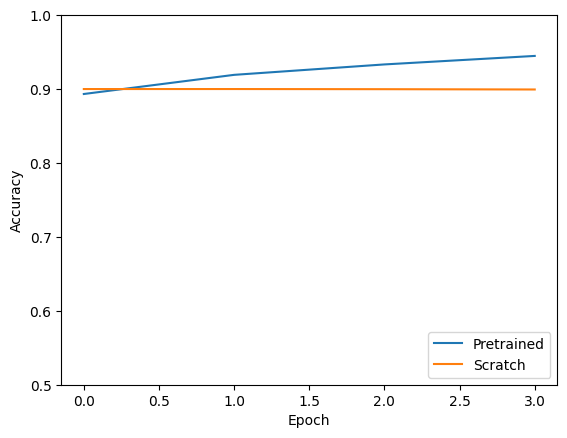

In [ ]:

# Plot the accuracy for both
plt.plot(history1.history['binary_accuracy'], label='Pretrained')
plt.plot(history_scratch.history['binary_accuracy'], label='Scratch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
